In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torchvision
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
#from torchsummary import summary
import numpy as np

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class NoisyFashionMNIST(Dataset):
    def __init__(self, root, train = True):
        """
        Creates a noisy dataset from the FashionMNIST
        """

        transform = transforms.ToTensor()
        self.noise = AddGaussianNoise(0., 0.1)
        self.dataset = datasets.FashionMNIST(root, train = train, download=True, transform = transform)

    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        return self.noise(img), img


Using device: cpu


In [20]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [21]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset_1 = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset_1 = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset_1.class_to_idx.items()}


# Classification
## Dataset

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


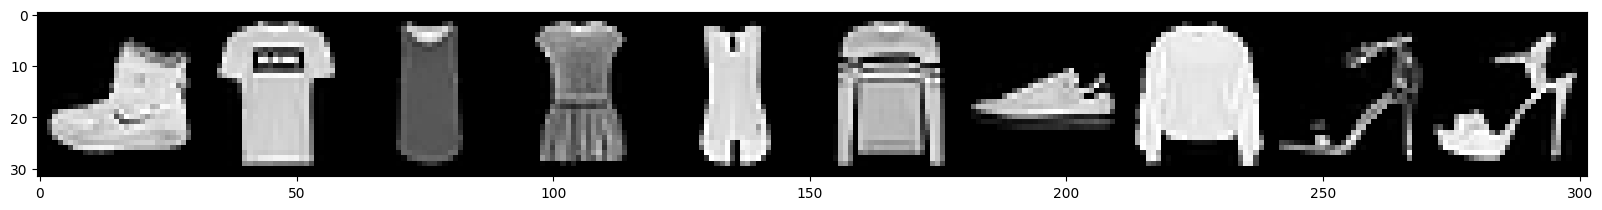

In [22]:
x = [train_dataset_1[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset_1[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

In [23]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_dataset_1,
                        batch_size=100,
                        shuffle=True,
                        #num_workers=1
                        ),

    'test'  : DataLoader(test_dataset_1,
                        batch_size=100,
                        shuffle=False,
                        #num_workers=1
                        ),
}

## Model

In [24]:
#Classification Model
from torch.autograd import Variable

class ClassifyNet(torch.nn.Module):
    def __init__(self, batch_norm: False):
        super().__init__()
        self.img_size = (28, 28)
        self.n_class = 10

        layers = [
            torch.nn.Conv2d(1, 10, kernel_size=5), # NxCxHxW   Nx10x24x24
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            torch.nn.Conv2d(10, 20, kernel_size=5), # NxCxHxW   Nx20x8x8
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx20x4x4

            torch.nn.Flatten(),
            torch.nn.Linear(320, self.n_class), # in: 20x4x4=320
            torch.nn.LogSoftmax(dim=1), # no need because of cross entropy loss
        ]

        if batch_norm:
            layers.insert(5, torch.nn.BatchNorm2d(20))
            layers.insert(1, torch.nn.BatchNorm2d(10))

        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        y = self.model(x)
        return torch.argmax(y, dim=1)

In [25]:
# Define Train/Test Functions
def train_epoch(model: torch.nn.Module, train_loader: DataLoader, f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, minimize: bool):
    epoch_loss = []

    for _, (batch_img, batch_target) in enumerate(train_loader):
        output = model(batch_img)

        if minimize:
            loss = f_loss(output, batch_target)
        else:
            loss = -f_loss(output, batch_target)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            epoch_loss += [loss.item()]

    return np.array(epoch_loss).mean()

@torch.no_grad()
def test(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    true_labels = []
    pred_labels = []
    for _, (batch_img, batch_targets) in enumerate(test_loader):
        y = model.predict(batch_img)

        pred_labels.append(y.numpy())
        true_labels.append(batch_targets.numpy())

    return np.array(pred_labels).flatten(), np.array(true_labels).flatten()

@torch.no_grad()
def eval(model: torch.nn.Module, eval_loader: DataLoader, f_loss: torch.nn.modules.loss, minimize: bool):
    model.eval()
    correct_predictions = 0
    test_loss = []

    for _, (batch_img, batch_targets) in enumerate(eval_loader):
        y = model.forward(batch_img)

        if minimize:
            loss = f_loss(y, batch_targets)
        else:
            loss = -f_loss(y, batch_targets)

        test_loss += [loss.item()]

        predictions = torch.argmax(y, dim=1)
        num_correct_predictions = torch.sum(predictions == batch_targets).item()
        correct_predictions += num_correct_predictions

    test_acc = correct_predictions / len(eval_loader.dataset)
    test_loss = np.array(test_loss).mean()

    return test_loss, test_acc, correct_predictions, len(eval_loader.dataset)

def train(model: torch.nn.Module, loaders: dict[DataLoader], f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, num_epochs=20, minimize: bool=True):
    model.train()

    train_loss = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        epoch_train_loss = train_epoch(model, loaders["train"], f_loss, optimizer, minimize)

        with torch.no_grad():
            epoch_test_loss, epoch_test_acc, corr_pred, num_pred = eval(model, loaders["test"], f_loss, minimize)

            print(f"epoch: {epoch} train_loss: {round(epoch_train_loss, 2)} "
                  f"test_loss: {round(epoch_test_loss, 2)} test_acc: {round(epoch_test_acc, 2)} ({corr_pred}/{num_pred})")

            train_loss.append(epoch_train_loss)
            test_loss.append(epoch_test_loss)
            test_acc.append(epoch_test_acc)

    return train_loss, test_loss, test_acc



## Training (with batch norm)

In [26]:
# Train Models
model_classify = ClassifyNet(True)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
f_loss = torch.nn.NLLLoss()

classify_train_loss_bn, classify_test_loss_bn, classify_test_acc_bn = train(model_classify, loaders, f_loss, optimizer, num_epochs=10)
classify_pred_labels, classify_true_labels = test(model_classify, loaders["test"])

epoch: 0 train_loss: 0.54 test_loss: 0.48 test_acc: 0.86 (8579/10000)
epoch: 1 train_loss: 0.36 test_loss: 0.35 test_acc: 0.88 (8757/10000)
epoch: 2 train_loss: 0.31 test_loss: 0.32 test_acc: 0.89 (8852/10000)
epoch: 3 train_loss: 0.29 test_loss: 0.31 test_acc: 0.89 (8896/10000)
epoch: 4 train_loss: 0.27 test_loss: 0.32 test_acc: 0.89 (8891/10000)
epoch: 5 train_loss: 0.26 test_loss: 0.31 test_acc: 0.89 (8886/10000)
epoch: 6 train_loss: 0.25 test_loss: 0.3 test_acc: 0.89 (8927/10000)
epoch: 7 train_loss: 0.24 test_loss: 0.3 test_acc: 0.89 (8937/10000)
epoch: 8 train_loss: 0.24 test_loss: 0.3 test_acc: 0.89 (8929/10000)
epoch: 9 train_loss: 0.23 test_loss: 0.31 test_acc: 0.89 (8898/10000)


## Evaluation

In [27]:
import pandas as pd

num_classes = len(idx_to_class.keys())

def show_results(pred_labels: list, true_labels: list):
    result_df = pd.DataFrame({"predictions": pred_labels, "ground_truth": true_labels})
    result_df = result_df.groupby(["predictions", "ground_truth"])["predictions"].count()

    # fill confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes))
    for index, value in result_df.to_dict().items():
        confusion_matrix[index] = value


    plt.imshow(confusion_matrix)
    plt.show()

    print(confusion_matrix)

    TP = confusion_matrix.diagonal()
    FP = confusion_matrix.sum(axis=1) - TP
    FN = confusion_matrix.sum(axis=0) - TP

    precision = np.round(TP / (TP + FP), 2)
    recall = np.round(TP / (TP + FN), 2)
    F1 = np.round(2*TP / (2*TP + FP + FN), 2)

    print()
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"FN: {FN}")
    print(f"precision: {precision} mean: {precision.mean()}")
    print(f"recall: {recall} mean: {recall.mean()}")
    print(f"F1: {F1} mean: {F1.mean()}")

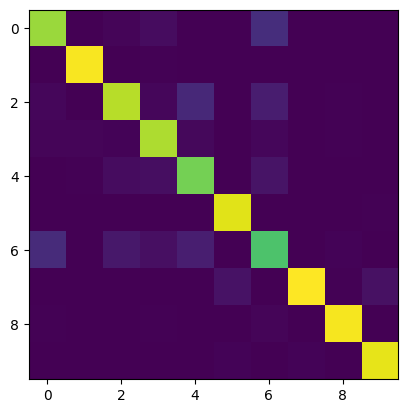

[[838.   0.  12.  34.   2.   0. 128.   0.   2.   0.]
 [  0. 976.   0.   6.   0.   0.   2.   0.   0.   0.]
 [ 17.   1. 882.  16. 114.   0.  78.   0.   4.   0.]
 [ 15.  15.   9. 863.  20.   0.  16.   0.   4.   0.]
 [  3.   5.  33.  36. 780.   0.  52.   0.   1.   0.]
 [  1.   0.   0.   0.   0. 942.   0.   3.   3.   7.]
 [121.   1.  63.  41.  84.   1. 709.   0.   9.   0.]
 [  0.   0.   0.   0.   0.  47.   0. 986.   4.  44.]
 [  5.   2.   1.   4.   0.   0.  15.   0. 973.   0.]
 [  0.   0.   0.   0.   0.  10.   0.  11.   0. 949.]]

TP: [838. 976. 882. 863. 780. 942. 709. 986. 973. 949.]
FP: [178.   8. 230.  79. 130.  14. 320.  95.  27.  21.]
FN: [162.  24. 118. 137. 220.  58. 291.  14.  27.  51.]
precision: [0.82 0.99 0.79 0.92 0.86 0.99 0.69 0.91 0.97 0.98] mean: 0.892
recall: [0.84 0.98 0.88 0.86 0.78 0.94 0.71 0.99 0.97 0.95] mean: 0.8899999999999999
F1: [0.83 0.98 0.84 0.89 0.82 0.96 0.7  0.95 0.97 0.96] mean: 0.8899999999999999


In [28]:
show_results(classify_pred_labels, classify_true_labels)

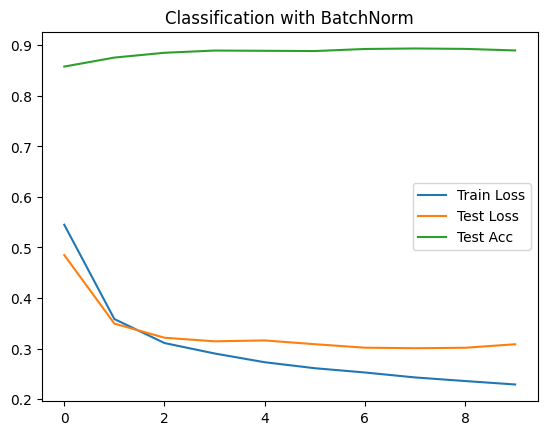

In [29]:
plt.plot(classify_train_loss_bn, label="Train Loss")
plt.plot(classify_test_loss_bn, label="Test Loss")
plt.plot(classify_test_acc_bn, label="Test Acc")
plt.title("Classification with BatchNorm")
plt.legend()
plt.show()

In [30]:
print(classification_report(classify_true_labels.tolist(), classify_pred_labels.tolist(), target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.79      0.88      0.84      1000
       Dress       0.92      0.86      0.89      1000
        Coat       0.86      0.78      0.82      1000
      Sandal       0.99      0.94      0.96      1000
       Shirt       0.69      0.71      0.70      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [31]:
def plot_example(pred_labels):
    rant_idx = np.random.choice(len(test_dataset_1.data), 10)

    x = [test_dataset_1[idx][0] for idx in rant_idx]
    labels = [idx_to_class[idx] for idx in pred_labels[rant_idx]]
    print(labels)

    plt.figure(figsize=(20,10))
    show(torchvision.utils.make_grid(x, nrow=10))
    plt.show()

['Ankle boot', 'Sandal', 'Ankle boot', 'Trouser', 'Sandal', 'Pullover', 'Sneaker', 'T-shirt/top', 'Sneaker', 'Dress']


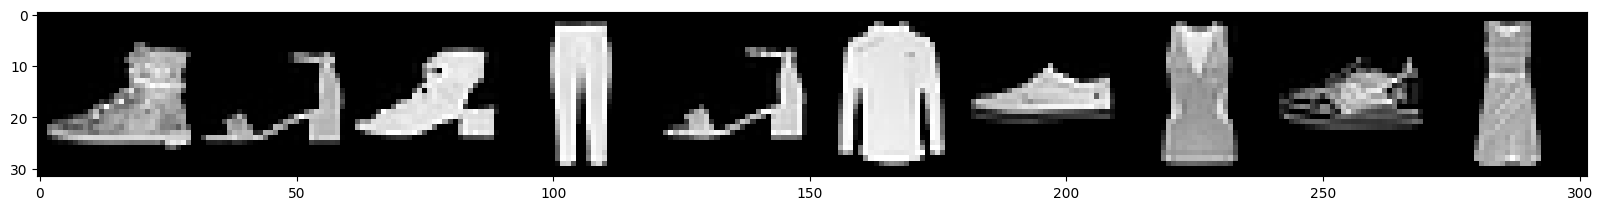

In [32]:
plot_example(classify_pred_labels)

## Training (Base Model)

In [12]:
# Train Models
model_classify = ClassifyNet(False)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
f_loss = torch.nn.NLLLoss()

classify_train_loss, classify_test_loss, classify_test_acc = train(model_classify, loaders, f_loss, optimizer, num_epochs=10)
classify_pred_labels, classify_true_labels = test(model_classify, loaders["test"])

epoch: 0 train_loss: 0.69 test_loss: 0.58 test_acc: 0.82 (8194/10000)
epoch: 1 train_loss: 0.46 test_loss: 0.44 test_acc: 0.85 (8469/10000)
epoch: 2 train_loss: 0.4 test_loss: 0.4 test_acc: 0.86 (8598/10000)
epoch: 3 train_loss: 0.37 test_loss: 0.38 test_acc: 0.87 (8664/10000)
epoch: 4 train_loss: 0.35 test_loss: 0.41 test_acc: 0.85 (8534/10000)
epoch: 5 train_loss: 0.33 test_loss: 0.35 test_acc: 0.88 (8777/10000)
epoch: 6 train_loss: 0.32 test_loss: 0.33 test_acc: 0.88 (8820/10000)
epoch: 7 train_loss: 0.31 test_loss: 0.33 test_acc: 0.88 (8845/10000)
epoch: 8 train_loss: 0.3 test_loss: 0.33 test_acc: 0.88 (8820/10000)
epoch: 9 train_loss: 0.29 test_loss: 0.32 test_acc: 0.89 (8851/10000)


### Evaluation

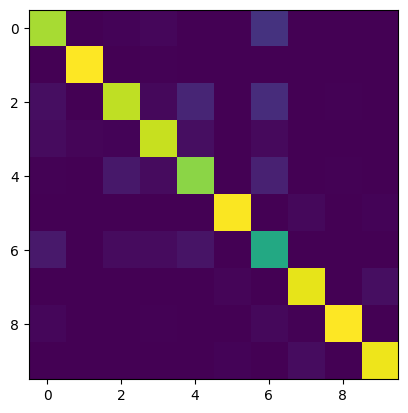

[[849.   2.  11.  19.   2.   0. 145.   0.   0.   0.]
 [  0. 975.   2.   6.   1.   0.   2.   0.   1.   0.]
 [ 35.   1. 884.  21. 101.   0. 123.   0.   7.   0.]
 [ 27.  15.   8. 894.  35.   0.  26.   0.   3.   0.]
 [  5.   2.  62.  28. 809.   0.  91.   0.   4.   0.]
 [  1.   0.   0.   0.   0. 974.   0.  21.   1.   9.]
 [ 67.   3.  30.  28.  50.   1. 591.   0.   3.   0.]
 [  0.   0.   0.   0.   0.  14.   0. 943.   3.  35.]
 [ 16.   2.   3.   4.   2.   3.  22.   5. 978.   2.]
 [  0.   0.   0.   0.   0.   8.   0.  31.   0. 954.]]

TP: [849. 975. 884. 894. 809. 974. 591. 943. 978. 954.]
FP: [179.  12. 288. 114. 192.  32. 182.  52.  59.  39.]
FN: [151.  25. 116. 106. 191.  26. 409.  57.  22.  46.]
precision: [0.83 0.99 0.75 0.89 0.81 0.97 0.76 0.95 0.94 0.96] mean: 0.8850000000000001
recall: [0.85 0.98 0.88 0.89 0.81 0.97 0.59 0.94 0.98 0.95] mean: 0.884
F1: [0.84 0.98 0.81 0.89 0.81 0.97 0.67 0.95 0.96 0.96] mean: 0.884


In [14]:
show_results(classify_pred_labels, classify_true_labels)

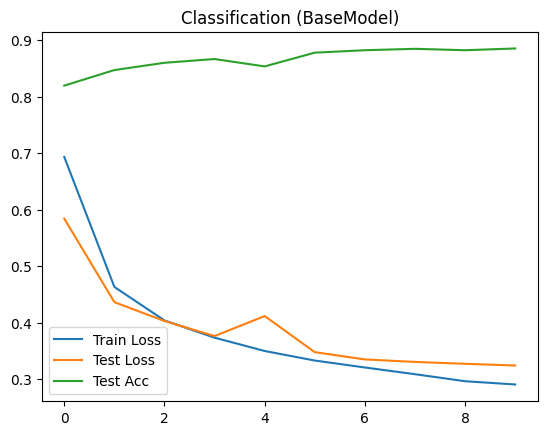

In [15]:
plt.plot(classify_train_loss, label="Train Loss")
plt.plot(classify_test_loss, label="Test Loss")
plt.plot(classify_test_acc, label="Test Acc")
plt.title("Classification (BaseModel)")
plt.legend()
plt.show()

In [16]:
print(classification_report(classify_true_labels.tolist(), classify_pred_labels.tolist(), target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.75      0.88      0.81      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.81      0.81      0.81      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.76      0.59      0.67      1000
     Sneaker       0.95      0.94      0.95      1000
         Bag       0.94      0.98      0.96      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.88      0.89      0.88     10000



['Sandal', 'Coat', 'Shirt', 'Trouser', 'Sneaker', 'Sneaker', 'Dress', 'Dress', 'T-shirt/top', 'Coat']


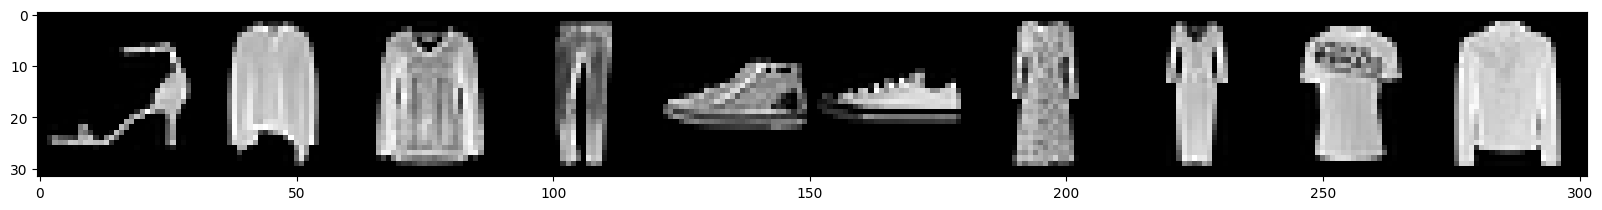

In [17]:
plot_example(classify_pred_labels)

## Classification with deeper model

In [60]:
class ClassifyNetDeep(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.img_size = (28, 28)
        self.n_class = 10

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 20, kernel_size=3), # NxCxHxW   Nx20x26x26
            torch.nn.BatchNorm2d(20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx20x12x12

            torch.nn.Conv2d(20, 30, kernel_size=3), # NxCxHxW   Nx30x10x10
            torch.nn.BatchNorm2d(30),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx30x5x5

            torch.nn.Conv2d(30, 40, kernel_size=3), # NxCxHxW   Nx40x3x3
            torch.nn.BatchNorm2d(40),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),

            torch.nn.Flatten(),
            torch.nn.Linear(360, self.n_class), # in: 40x3x3=360
            torch.nn.LogSoftmax(dim=1), # no need because of cross entropy loss
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        y = self.model(x)
        return torch.argmax(y, dim=1)

### Training deeper model

In [61]:
# Train Models
model_classify = ClassifyNetDeep()
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
f_loss = torch.nn.NLLLoss()

classify_train_loss_d, classify_test_loss_d, classify_test_acc_d = train(model_classify, loaders, f_loss, optimizer, num_epochs=10)
classify_pred_labels, classify_true_labels = test(model_classify, loaders["test"])

epoch: 0 train_loss: 0.52 test_loss: 0.5 test_acc: 0.83 (8341/10000)
epoch: 1 train_loss: 0.33 test_loss: 0.32 test_acc: 0.88 (8817/10000)
epoch: 2 train_loss: 0.28 test_loss: 0.29 test_acc: 0.89 (8944/10000)
epoch: 3 train_loss: 0.26 test_loss: 0.28 test_acc: 0.9 (8993/10000)
epoch: 4 train_loss: 0.24 test_loss: 0.28 test_acc: 0.9 (8952/10000)
epoch: 5 train_loss: 0.22 test_loss: 0.28 test_acc: 0.9 (8977/10000)
epoch: 6 train_loss: 0.21 test_loss: 0.28 test_acc: 0.9 (9007/10000)
epoch: 7 train_loss: 0.2 test_loss: 0.27 test_acc: 0.9 (9044/10000)
epoch: 8 train_loss: 0.19 test_loss: 0.28 test_acc: 0.9 (9022/10000)
epoch: 9 train_loss: 0.18 test_loss: 0.27 test_acc: 0.91 (9067/10000)


### Evaluation

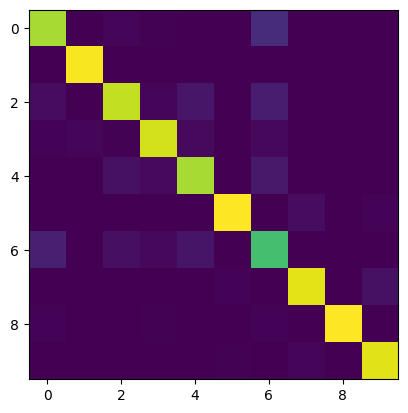

[[858.   2.  13.   7.   1.   0. 125.   0.   2.   0.]
 [  0. 977.   0.   3.   0.   0.   0.   0.   0.   0.]
 [ 33.   1. 897.  16.  59.   0.  80.   0.   3.   0.]
 [ 11.  17.   6. 920.  25.   0.  22.   0.   2.   0.]
 [  3.   1.  43.  24. 857.   0.  69.   0.   3.   0.]
 [  0.   0.   0.   0.   0. 987.   0.  34.   3.  11.]
 [ 86.   1.  41.  22.  55.   0. 695.   0.   0.   0.]
 [  1.   0.   0.   0.   0.   8.   0. 948.   2.  46.]
 [  8.   1.   0.   7.   3.   0.   9.   0. 985.   0.]
 [  0.   0.   0.   1.   0.   5.   0.  18.   0. 943.]]

TP: [858. 977. 897. 920. 857. 987. 695. 948. 985. 943.]
FP: [150.   3. 192.  83. 143.  48. 205.  57.  28.  24.]
FN: [142.  23. 103.  80. 143.  13. 305.  52.  15.  57.]
precision: [0.85 1.   0.82 0.92 0.86 0.95 0.77 0.94 0.97 0.98] mean: 0.906
recall: [0.86 0.98 0.9  0.92 0.86 0.99 0.7  0.95 0.98 0.94] mean: 0.908
F1: [0.85 0.99 0.86 0.92 0.86 0.97 0.73 0.95 0.98 0.96] mean: 0.907


In [64]:
show_results(classify_pred_labels, classify_true_labels)

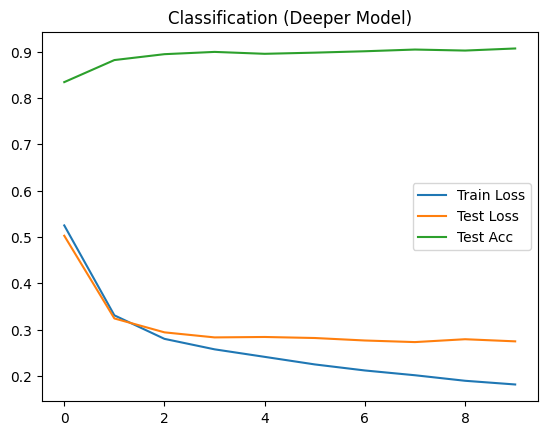

In [65]:
plt.plot(classify_train_loss_d, label="Train Loss")
plt.plot(classify_test_loss_d, label="Test Loss")
plt.plot(classify_test_acc_d, label="Test Acc")
plt.title("Classification (Deeper Model)")
plt.legend()
plt.show()

In [66]:
print(classification_report(classify_true_labels.tolist(), classify_pred_labels.tolist(), target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.82      0.90      0.86      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.86      0.86      0.86      1000
      Sandal       0.95      0.99      0.97      1000
       Shirt       0.77      0.69      0.73      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



['Pullover', 'Bag', 'Sandal', 'Sneaker', 'Ankle boot', 'Dress', 'Dress', 'Shirt', 'Sandal', 'Ankle boot']


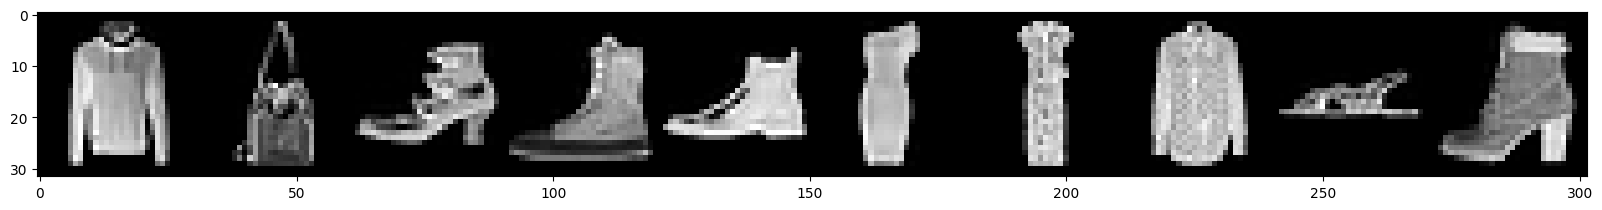

In [67]:
plot_example(classify_pred_labels)

## Classifcation with Resual connections

In [48]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
      super().__init__()
      self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
      self.batch1 = torch.nn.BatchNorm2d(out_channels)
      self.relu1 = torch.nn.ReLU()
      self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
      self.batch2 = torch.nn.BatchNorm2d(out_channels)
      self.relu2 = torch.nn.ReLU()
      if in_channels != out_channels:
          self.matching_conv = torch.nn.Conv2d(in_channels, out_channels, 1)  # 1x1 conv
      else:
          self.matching_conv = None

    def forward(self,x):
      residual = x
      if self.matching_conv is not None:
          residual = self.matching_conv(residual)  # Change the number of channels in residual to match out
      out = self.conv1(x)
      out = self.batch1(out)
      out = self.relu1(out)
      out = self.conv2(out)
      out = self.batch2(out)
      out += residual
      out = self.relu2(out)
      return out

class ResClassNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.img_size = (28, 28)
        self.n_class = 10

        self.model = torch.nn.Sequential(
            ResidualBlock(1,10),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            ResidualBlock(10,20),
            torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx20x4x4

            torch.nn.Flatten(),
            torch.nn.Linear(980, self.n_class), # in: 20x4x4=320
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

    @ torch.no_grad()
    def predict(self, x):
        self.model.eval()
        y = self.model(x)
        return torch.argmax(y, dim=1)
    

In [50]:
# Train Models
model_classify = ResClassNet()
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
f_loss = torch.nn.NLLLoss()

classify_train_loss_res, classify_test_loss_res, classify_test_acc_res = train(model_classify, loaders, f_loss, optimizer, num_epochs=10)
classify_pred_labels, classify_true_labels = test(model_classify, loaders["test"])

epoch: 0 train_loss: 0.45 test_loss: 0.42 test_acc: 0.85 (8519/10000)
epoch: 1 train_loss: 0.3 test_loss: 0.3 test_acc: 0.89 (8941/10000)
epoch: 2 train_loss: 0.25 test_loss: 0.27 test_acc: 0.9 (9017/10000)
epoch: 3 train_loss: 0.23 test_loss: 0.28 test_acc: 0.9 (8987/10000)
epoch: 4 train_loss: 0.21 test_loss: 0.26 test_acc: 0.91 (9052/10000)
epoch: 5 train_loss: 0.2 test_loss: 0.25 test_acc: 0.91 (9094/10000)
epoch: 6 train_loss: 0.19 test_loss: 0.27 test_acc: 0.9 (9035/10000)
epoch: 7 train_loss: 0.18 test_loss: 0.27 test_acc: 0.91 (9119/10000)
epoch: 8 train_loss: 0.17 test_loss: 0.27 test_acc: 0.91 (9116/10000)
epoch: 9 train_loss: 0.16 test_loss: 0.26 test_acc: 0.92 (9152/10000)


## Evaluation

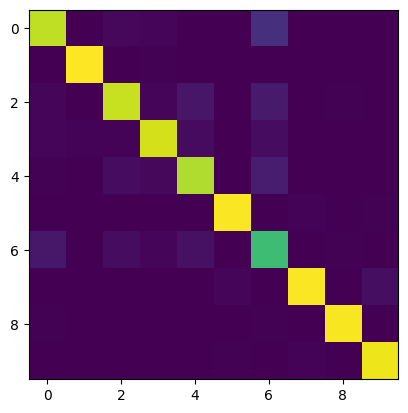

[[892.   2.  21.  19.   1.   0. 133.   0.   3.   0.]
 [  2. 986.   1.   5.   0.   0.   0.   0.   2.   1.]
 [ 19.   0. 902.  12.  58.   0.  70.   0.   5.   0.]
 [ 17.  11.   8. 924.  28.   0.  33.   0.   3.   0.]
 [  4.   1.  33.  20. 868.   0.  79.   0.   2.   0.]
 [  0.   0.   0.   0.   0. 982.   0.   9.   2.   4.]
 [ 62.   0.  34.  18.  44.   0. 680.   0.   4.   0.]
 [  0.   0.   0.   0.   0.  13.   0. 980.   1.  35.]
 [  4.   0.   1.   2.   1.   0.   5.   0. 978.   0.]
 [  0.   0.   0.   0.   0.   5.   0.  11.   0. 960.]]

TP: [892. 986. 902. 924. 868. 982. 680. 980. 978. 960.]
FP: [179.  11. 164. 100. 139.  15. 162.  49.  13.  16.]
FN: [108.  14.  98.  76. 132.  18. 320.  20.  22.  40.]
precision: [0.83 0.99 0.85 0.9  0.86 0.98 0.81 0.95 0.99 0.98] mean: 0.914
recall: [0.89 0.99 0.9  0.92 0.87 0.98 0.68 0.98 0.98 0.96] mean: 0.9150000000000003
F1: [0.86 0.99 0.87 0.91 0.86 0.98 0.74 0.97 0.98 0.97] mean: 0.913


In [51]:
show_results(classify_pred_labels, classify_true_labels)

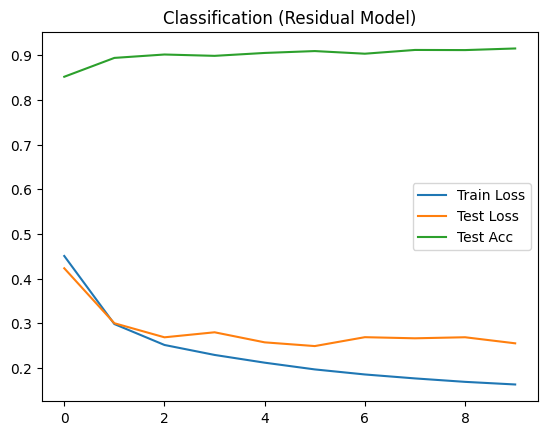

In [68]:
plt.plot(classify_train_loss_res, label="Train Loss")
plt.plot(classify_test_loss_res, label="Test Loss")
plt.plot(classify_test_acc_res, label="Test Acc")
plt.title("Classification (Residual Model)")
plt.legend()
plt.show()

In [53]:
print(classification_report(classify_true_labels.tolist(), classify_pred_labels.tolist(), target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.89      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.85      0.90      0.87      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.86      0.87      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.81      0.68      0.74      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.91      0.92      0.91     10000
weighted avg       0.91      0.92      0.91     10000



['Pullover', 'Ankle boot', 'Dress', 'Pullover', 'Sneaker', 'Bag', 'Pullover', 'Bag', 'T-shirt/top', 'Bag']


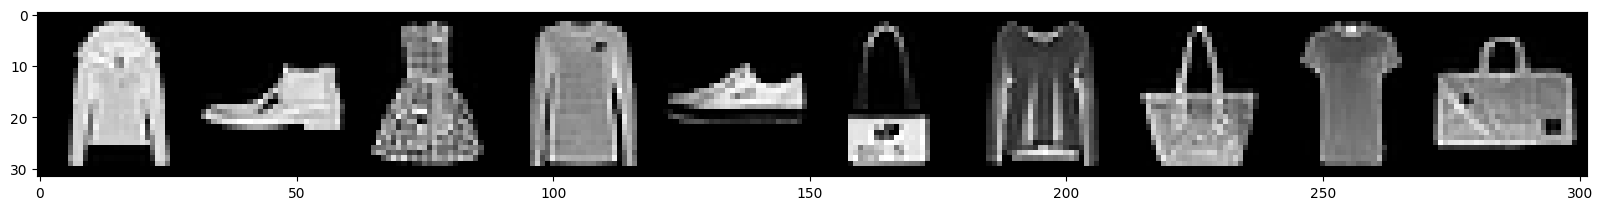

In [54]:
plot_example(classify_pred_labels)

# Evaluate Classification Models

In [97]:
def plot_summery(
        train_losses,
        test_losses,
        test_accs,
        names,
        with_acc: bool=True
):
    if with_acc:
        num_plots = 3
    else:
        num_plots = 2
    
    plt.figure(figsize=(16,4))
    plt.subplot(1, num_plots, 1)
    for loss, name in zip(train_losses, names):
        plt.plot(loss, label=name)
    plt.title("Train Loss")
    #plt.show()

    plt.subplot(1, num_plots, 2)
    for loss, name in zip(test_losses, names):
        plt.plot(loss, label=name)
    plt.title("Test Loss")
    #plt.show()

    if with_acc:
        plt.subplot(1, num_plots, 3)
        for acc, name in zip(test_accs, names):
            plt.plot(acc, label=name)
        plt.title("Test Accuracy")
    plt.legend()

In [98]:
class_train_losses = [classify_train_loss, classify_train_loss_bn, classify_train_loss_d, classify_train_loss_res]
class_test_losses = [classify_test_loss, classify_test_loss_bn, classify_test_loss_d, classify_test_loss_res]
class_test_accs = [classify_test_acc, classify_test_acc_bn, classify_test_acc_d, classify_test_acc_res]

models = ["Base Model", "Model with BachNorm", "Deeper Model", "Model with Residual Connections"]

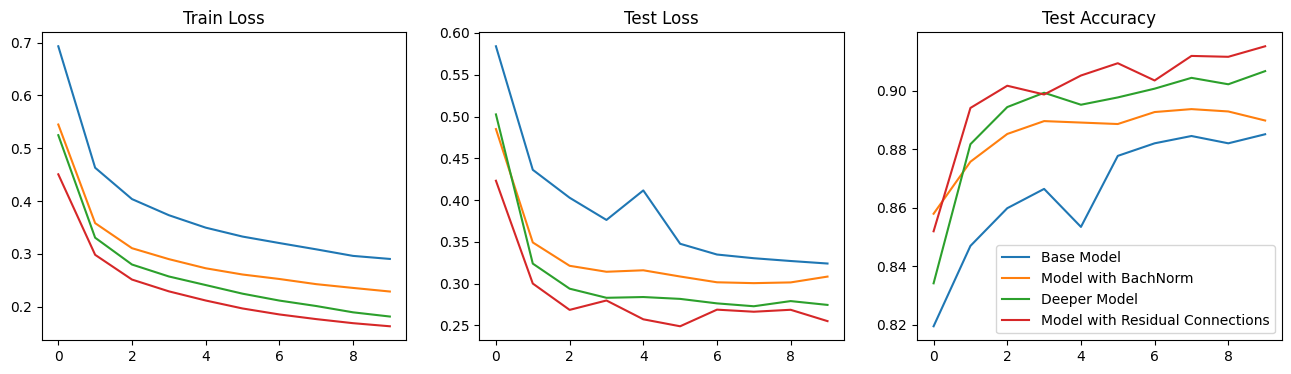

In [99]:
plot_summery(class_train_losses, class_test_losses, class_test_accs, models)

We can clearly see that the Base Model performs the worst. Residual Connetions can improve a network significantly. They also allow the network to have more layer which can improve the performance further.